In [15]:

from tqdm import tqdm
import numpy as np
from sklearn.decomposition import PCA
import random  # Add import for random module
random.seed(10)

class Node:
    def __init__(self, data_indices, depth):
        self.data_indices = data_indices
        self.depth = depth
        self.left = None
        self.right = None
        self.split_dim = None
        self.split_value = None
        self.label = None

def create_data_matrix( X_train ):
    X = X_train.reshape(-1, 784)
    X = X.T
    return X


def center_data(X, mean=None):
    if mean is None:
        mean = np.mean(X, axis=1, keepdims=True)
    X_centered = X - mean
    return X_centered, mean

def apply_pca(X_centered, p):
    covariance_matrix = np.matmul(X_centered, X_centered.T) / (X_centered.shape[1] - 1)
    V, U = np.linalg.eigh(covariance_matrix)

    sorted_indices = np.argsort(V)[::-1]
    U_sorted = U[:, sorted_indices][:, :p]

    Y = U_sorted.T @ X_centered
    return U_sorted, Y

def reconstruct_data(U_sorted, Y):
    X_recon = U_sorted @ Y
    return X_recon

def calculate_mse(X_centered, X_recon):
    mse = np.sum((X_centered - X_recon) ** 2) / X_centered.size
    return mse

def plot_reconstructed_images(X_recon_p, p):
    fig, axes = plt.subplots(10, 5, figsize=(10, 10))
    for i in range(10):
        for j in range(5):
            axes[i, j].imshow(X_recon_p[:, i * 100 + j].reshape(28, 28), cmap='cubehelix_r')
            axes[i, j].axis('off')

    plt.suptitle(f"Reconstructed Images with p={p}")
    plt.show()

def calculate_class_accuracy(y_true, y_pred):

    num_classes = 3
    accuracy_per_class = np.zeros(num_classes)
    total_per_class = np.zeros(num_classes)

    for true_label, pred_label in zip(y_true, y_pred):
        total_per_class[true_label] += 1
        if true_label == pred_label:
            accuracy_per_class[true_label] += 1

    accuracy_per_class = accuracy_per_class / total_per_class
    return accuracy_per_class



def print_tree(root, level=0, prefix="Root:"):
    if root is not None:
        print(" " * (level * 4) + prefix, root.label)
        if root.left is not None or root.right is not None:
            if root.left is not None:
                print_tree(root.left, level + 1, prefix="L--")
            else:
                print(" " * ((level + 1) * 4) + "L--None")
            if root.right is not None:
                print_tree(root.right, level + 1, prefix="R--")
            else:
                print(" " * ((level + 1) * 4) + "R--None")



def SSR(y):
    mean_y = np.mean(y)
    return np.sum((y - mean_y)**2 )

def find_best_split(X, y, data_indices):
    n_samples, n_features = X[data_indices].shape
    
    best_loss = float('inf')
    best_split_dim = None
    best_split_value = None
    
    for dim in range(n_features):
        unique_values = np.unique(X[data_indices, dim])
        
        for i in range(len(unique_values) - 1):
            value = (unique_values[i] + unique_values[i + 1]) / 2  # Midpoint split
            left_indices = data_indices[X[data_indices, dim] <= value]
            right_indices = data_indices[X[data_indices, dim] > value]
            
            # Calculate SSR for left and right splits
            SSR_left = SSR(y[left_indices])
            SSR_right = SSR(y[right_indices])
            
            # Calculate total SSR for the split
            total_SSR = SSR_left + SSR_right
            
            if total_SSR < best_loss:
                best_loss = total_SSR
                best_split_dim = dim
                best_split_value = value
                
    return best_split_dim, best_split_value, best_loss
    

def assign_label_for_node(node, y):
    node.label = np.mean(y[node.data_indices])
    return node

def check_stopping_criteria(depth, max_depth):
    if depth >= max_depth:
        return True
    return False

def grow_tree(X, y, data_indices=None, depth=0, max_depth=1):
    global total_leaf_nodes
    
    if data_indices is None:
        data_indices = np.arange(X.shape[0])

    n_samples, n_features = X[data_indices].shape

    node= Node(data_indices=data_indices, depth=depth)

    if check_stopping_criteria(depth, max_depth):
        assign_label_for_node(node, y)
        total_leaf_nodes += 1
        return node, None

    best_split_dim, best_split_value,best_loss = find_best_split(X, y, data_indices)
    
    left_indices = data_indices[X[data_indices, best_split_dim] <= best_split_value]
    right_indices = data_indices[X[data_indices, best_split_dim] > best_split_value]

    node.split_dim = best_split_dim
    node.split_value = best_split_value

    node.left, _ = grow_tree(X, y, left_indices, depth=depth + 1, max_depth=max_depth)
    node.right, _ = grow_tree(X, y, right_indices, depth=depth + 1, max_depth=max_depth)

    return node, best_loss

def predict(x, node):
    if node.label is not None:
        return node.label
    if x[node.split_dim] <= node.split_value:
        return predict(x, node.left)
    else:
        return predict(x, node.right)

# # Load MNIST dataset
# mnist_data = np.load(r"D:\Downloads\mnist.npz")
# x_train, y_train = mnist_data['x_train'], mnist_data['y_train']

# # Select classes 0, 1
# selected_indices = np.where((y_train == 0) | (y_train == 1))[0]
# x_selected = x_train[selected_indices]
# y_selected = y_train[selected_indices]

# # Select 1000 samples from each class for validation
# class_0_indices = np.where(y_selected == 0)[0][:500]
# class_1_indices = np.where(y_selected == 1)[0][:500]
# val_indices = np.concatenate([class_0_indices, class_1_indices])

# x_val = x_selected[val_indices]
# y_val = y_selected[val_indices]

# # Remove validation samples from the training set
# x_train = np.delete(x_selected, val_indices, axis=0)
# y_train = np.delete(y_selected, val_indices)

# test_indices = []
# for i in range(2):  # For each class
#     class_indices = np.where(y_train == i)[0]
#     remaining_indices = np.setdiff1d(class_indices, val_indices)
#     test_indices.extend(remaining_indices[:500])  # Select 500 from each class

# x_test = x_train[test_indices]
# y_test = y_train[test_indices]

# # Remove test samples from the training set
# x_train = np.delete(x_train, test_indices, axis=0)
# y_train = np.delete(y_train, test_indices)

# # Verify shapes
# print("Shapes:")
# print("Training set:", x_train.shape, y_train.shape)
# print("Validation set:", x_val.shape, y_val.shape)
# print("Test set:", x_test.shape, y_test.shape)


# X = create_data_matrix(x_train)
# X_centered,X_train_mean = center_data(X)
# p = 5
# U_sorted, x_reduced = apply_pca(X_centered, p)
# x_reduced = x_reduced.T
# print(x_reduced.shape)


# X = create_data_matrix(x_val)
# X_centered_val,X_val_mean = center_data(X,X_train_mean)
# p = 5
# x_reduced_val = U_sorted.T @ X_centered_val
# x_reduced_val = x_reduced_val.T
# print(x_reduced_val.shape)



# X = create_data_matrix(x_test)
# X_centered_test,X_test_mean = center_data(X,X_train_mean)
# p = 5
# x_reduced_test = U_sorted.T @ X_centered_test
# x_reduced_test = x_reduced_test.T
# print(x_reduced_test.shape)

import numpy as np

# Load MNIST dataset
mnist_data = np.load(r"D:\Downloads\mnist.npz")
x_train_all, y_train_all = mnist_data['x_train'], mnist_data['y_train']
x_test_all, y_test_all = mnist_data['x_test'], mnist_data['y_test']

# Select classes 0 and 1
selected_train_indices = np.where((y_train_all == 0) | (y_train_all == 1))[0]
selected_test_indices = np.where((y_test_all == 0) | (y_test_all == 1))[0]

x_selected_train = x_train_all[selected_train_indices]
y_selected_train = y_train_all[selected_train_indices]
x_selected_test = x_test_all[selected_test_indices]
y_selected_test = y_test_all[selected_test_indices]

# Sample 1000 samples randomly from each class for validation
num_val_samples_per_class = 1000

# Initialize empty lists to store indices
val_indices = []

# For each class (0 and 1)
for class_label in [0, 1]:
    # Find indices of samples belonging to the current class in the training set
    class_indices_train = np.where(y_selected_train == class_label)[0]

    # Randomly select validation samples
    val_indices.extend(np.random.choice(class_indices_train, size=num_val_samples_per_class, replace=False))

# Convert list to numpy array
val_indices = np.array(val_indices)

# Remove validation samples from the training set
x_train = np.delete(x_selected_train, val_indices, axis=0)
y_train = np.delete(y_selected_train, val_indices)

# Separate validation set
x_val = x_selected_train[val_indices]
y_val = y_selected_train[val_indices]

# Verify shapes
print("Shapes:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

# x_test should contain all samples from the original x_test_all
x_test = x_selected_test
y_test = y_selected_test

# Verify shapes
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

X = create_data_matrix(x_train)
X_centered,X_train_mean = center_data(X)
p = 5
U_sorted, x_reduced = apply_pca(X_centered, p)
x_reduced = x_reduced.T
print(x_reduced.shape)


X = create_data_matrix(x_val)
X_centered_val,X_val_mean = center_data(X,X_train_mean)
p = 5
x_reduced_val = U_sorted.T @ X_centered_val
x_reduced_val = x_reduced_val.T
print(x_reduced_val.shape)



X = create_data_matrix(x_test)
X_centered_test,X_test_mean = center_data(X,X_train_mean)
p = 5
x_reduced_test = U_sorted.T @ X_centered_test
x_reduced_test = x_reduced_test.T
print(x_reduced_test.shape)




# def reg_boost(X, y, X_val, y_val, num_iterations):
    
#     classifiers = []  # Store the decision trees
#     validation_mse = []  # Store validation MSE
#     l = 0.01
#     global total_leaf_nodes
#     y_cap = np.array(y[:],dtype=np.float32)
#     y_val = np.array(y_val[:],dtype=np.float32)
#     for _ in tqdm(range(num_iterations)):
#         # Create a decision tree using the dataset
#         total_leaf_nodes = 0    
#         tree, best_loss = grow_tree(X, y_cap)
#         predictions = np.array([predict(x, tree) for x in X],dtype=np.float32)
#         y_cap = np.sign(y_cap - predictions)
        
#         classifiers.append(tree)

#         train_predictions = reg_boost_predict(classifiers,X)
#         # Calculate MSE on the validation set
#         mse = np.mean((y - train_predictions) ** 2)
#         print(f"Iteration {_+1}: Training MSE Regres Boost= {mse}")
#         validation_mse.append(mse)

        
#         # Calculate predictions on the validation set
#         val_predictions = reg_boost_predict(classifiers,X_val)
#         # Calculate MSE on the validation set
#         mse = np.mean((val_predictions - y_val) ** 2)
#         print(f"Iteration {_+1}: Validation MSE Regres Boost= {mse}")
#         validation_mse.append(mse)
        
#     return classifiers, validation_mse


# def reg_boost_predict(classifiers, X):
#     l = 0.01
#     predictions = np.zeros(len(X))
    
#     for tree in classifiers:
#         prediction = np.array([predict(x, tree) for x in X],dtype=np.float32)
#         # prediction[prediction == 0] = -1  # Change 0 to -1
#         predictions += (l * (prediction ))
    
#     return prediction
def reg_boost(X, y, X_val, y_val, num_iterations):
    
    classifiers = []  # Store the decision trees
    validation_mse = []  # Store validation MSE
    l = 0.01  # Learning rate
    global total_leaf_nodes
    y_cap = np.array(y[:], dtype=np.float32)
    y_val = np.array(y_val[:], dtype=np.float32)
    
    for idx in tqdm(range(num_iterations)):
        # Create a decision tree using the dataset
        total_leaf_nodes = 0    
        tree, _ = grow_tree(X, y_cap)
        predictions = np.array([predict(x, tree) for x in X], dtype=np.float32)
        # Update y_cap using gradient descent with absolute loss
        y_cap -= l * np.sign( y_cap-predictions )
        
        classifiers.append(tree)

        # Calculate train MSE
        train_predictions = reg_boost_predict(classifiers, X)
        train_mse = np.mean((y - train_predictions) ** 2)
        print(f"Iteration {idx+1}: Training MSE Regres Boost = {train_mse}")

        # Calculate validation MSE
        val_predictions = reg_boost_predict(classifiers, X_val)
        val_mse = np.mean((val_predictions - y_val) ** 2)
        print(f"Iteration {idx+1}: Validation MSE Regres Boost = {val_mse}")
        validation_mse.append(val_mse)
        
    return classifiers, validation_mse

def reg_boost_predict(classifiers, X):
    l = 0.01
    predictions = np.zeros(len(X))
    
    for tree in classifiers:
        prediction = np.array([predict(x, tree) for x in X], dtype=np.float32)
        predictions += l * prediction
    
    return predictions


# Example usage:
# classifiers = ada_boost(x_reduced, y_train, num_iterations,)
# Example usage:
num_iterations = 300
classifiers, validation_accuracies = reg_boost(x_reduced, y_train, x_reduced_val,y_val, num_iterations)

# Example usage:
# predictions = ada_boost_predict(classifiers, x_val)


Shapes:
x_train: (10665, 28, 28)
y_train: (10665,)
x_val: (2000, 28, 28)
y_val: (2000,)
x_test: (2115, 28, 28)
y_test: (2115,)
(10665, 5)
(2000, 5)
(2115, 5)


  0%|▎                                                                                 | 1/300 [00:10<50:52, 10.21s/it]

Iteration 1: Training MSE Regres Boost = 0.5277753872585863
Iteration 1: Validation MSE Regres Boost = 0.4901132142178462


  1%|▌                                                                                 | 2/300 [00:20<51:34, 10.38s/it]

Iteration 2: Training MSE Regres Boost = 0.5173646043495899
Iteration 2: Validation MSE Regres Boost = 0.4804229255600414


  1%|▊                                                                                 | 3/300 [00:30<50:37, 10.23s/it]

Iteration 3: Training MSE Regres Boost = 0.5071611582487052
Iteration 3: Validation MSE Regres Boost = 0.47092622734253803


  1%|█                                                                                 | 4/300 [00:40<49:53, 10.11s/it]

Iteration 4: Training MSE Regres Boost = 0.4971619894584606
Iteration 4: Validation MSE Regres Boost = 0.46162027093596186


  2%|█▎                                                                                | 5/300 [00:50<49:25, 10.05s/it]

Iteration 5: Training MSE Regres Boost = 0.4873641050731586
Iteration 5: Validation MSE Regres Boost = 0.45250227376243274


  2%|█▋                                                                                | 6/300 [01:00<49:01, 10.01s/it]

Iteration 6: Training MSE Regres Boost = 0.47776456617472884
Iteration 6: Validation MSE Regres Boost = 0.4435695075644779


  2%|█▉                                                                                | 7/300 [01:10<49:28, 10.13s/it]

Iteration 7: Training MSE Regres Boost = 0.4683604871428256
Iteration 7: Validation MSE Regres Boost = 0.4348192977631282


  3%|██▏                                                                               | 8/300 [01:20<48:57, 10.06s/it]

Iteration 8: Training MSE Regres Boost = 0.45914905067481443
Iteration 8: Validation MSE Regres Boost = 0.42624903743699166


  3%|██▍                                                                               | 9/300 [01:31<49:09, 10.14s/it]

Iteration 9: Training MSE Regres Boost = 0.4501274963742651
Iteration 9: Validation MSE Regres Boost = 0.41785617670130015


  3%|██▋                                                                              | 10/300 [01:41<48:59, 10.14s/it]

Iteration 10: Training MSE Regres Boost = 0.4412931208458468
Iteration 10: Validation MSE Regres Boost = 0.4096382227960379


  4%|██▉                                                                              | 11/300 [01:51<48:17, 10.03s/it]

Iteration 11: Training MSE Regres Boost = 0.4326432777869807
Iteration 11: Validation MSE Regres Boost = 0.4015927401736619


  4%|███▏                                                                             | 12/300 [02:00<47:38,  9.92s/it]

Iteration 12: Training MSE Regres Boost = 0.42417537896279345
Iteration 12: Validation MSE Regres Boost = 0.39371735140386555


  4%|███▌                                                                             | 13/300 [02:10<47:26,  9.92s/it]

Iteration 13: Training MSE Regres Boost = 0.4158869021349922
Iteration 13: Validation MSE Regres Boost = 0.38600974455176007


  5%|███▊                                                                             | 14/300 [02:20<47:03,  9.87s/it]

Iteration 14: Training MSE Regres Boost = 0.4077753785627281
Iteration 14: Validation MSE Regres Boost = 0.3784676615478418


  5%|████                                                                             | 15/300 [02:30<47:50, 10.07s/it]

Iteration 15: Training MSE Regres Boost = 0.3998383975629206
Iteration 15: Validation MSE Regres Boost = 0.3710889024329707


  5%|████▎                                                                            | 16/300 [02:40<47:28, 10.03s/it]

Iteration 16: Training MSE Regres Boost = 0.39207360825049
Iteration 16: Validation MSE Regres Boost = 0.36387132697495994


  6%|████▌                                                                            | 17/300 [02:50<47:07,  9.99s/it]

Iteration 17: Training MSE Regres Boost = 0.3844787228629816
Iteration 17: Validation MSE Regres Boost = 0.35681285776178634


  6%|████▊                                                                            | 18/300 [03:00<46:58, 10.00s/it]

Iteration 18: Training MSE Regres Boost = 0.3770515082198275
Iteration 18: Validation MSE Regres Boost = 0.34991147225958397


  6%|█████▏                                                                           | 19/300 [03:10<46:45,  9.98s/it]

Iteration 19: Training MSE Regres Boost = 0.36978978840317855
Iteration 19: Validation MSE Regres Boost = 0.34316520530351646


  7%|█████▍                                                                           | 20/300 [03:20<46:38, 10.00s/it]

Iteration 20: Training MSE Regres Boost = 0.36269145055197705
Iteration 20: Validation MSE Regres Boost = 0.3365721544841839


  7%|█████▋                                                                           | 21/300 [03:30<46:12,  9.94s/it]

Iteration 21: Training MSE Regres Boost = 0.355754439009171
Iteration 21: Validation MSE Regres Boost = 0.33013047471073076


  7%|█████▉                                                                           | 22/300 [03:40<45:57,  9.92s/it]

Iteration 22: Training MSE Regres Boost = 0.3489767585949033
Iteration 22: Validation MSE Regres Boost = 0.32383838124933256


  8%|██████▏                                                                          | 23/300 [03:50<45:47,  9.92s/it]

Iteration 23: Training MSE Regres Boost = 0.3423564697782635
Iteration 23: Validation MSE Regres Boost = 0.31769414523738265


  8%|██████▍                                                                          | 24/300 [04:00<45:29,  9.89s/it]

Iteration 24: Training MSE Regres Boost = 0.3358916923662023
Iteration 24: Validation MSE Regres Boost = 0.3116960971125353


  8%|██████▊                                                                          | 25/300 [04:10<45:15,  9.87s/it]

Iteration 25: Training MSE Regres Boost = 0.3295806089645601
Iteration 25: Validation MSE Regres Boost = 0.30584262982504257


  9%|███████                                                                          | 26/300 [04:20<45:19,  9.93s/it]

Iteration 26: Training MSE Regres Boost = 0.3234214567421229
Iteration 26: Validation MSE Regres Boost = 0.30013219119295464


  9%|███████▎                                                                         | 27/300 [04:30<45:25,  9.99s/it]

Iteration 27: Training MSE Regres Boost = 0.31741253177462464
Iteration 27: Validation MSE Regres Boost = 0.2945632879243879


  9%|███████▌                                                                         | 28/300 [04:40<45:13,  9.97s/it]

Iteration 28: Training MSE Regres Boost = 0.311552192124322
Iteration 28: Validation MSE Regres Boost = 0.28913448849617074


 10%|███████▊                                                                         | 29/300 [04:50<44:56,  9.95s/it]

Iteration 29: Training MSE Regres Boost = 0.30583885466904437
Iteration 29: Validation MSE Regres Boost = 0.2838444201973406


 10%|████████                                                                         | 30/300 [05:00<45:06, 10.02s/it]

Iteration 30: Training MSE Regres Boost = 0.30027099214104147
Iteration 30: Validation MSE Regres Boost = 0.27869176637765813


 10%|████████▎                                                                        | 31/300 [05:10<45:18, 10.11s/it]

Iteration 31: Training MSE Regres Boost = 0.2948471376800635
Iteration 31: Validation MSE Regres Boost = 0.2736752706811203


 11%|████████▋                                                                        | 32/300 [05:20<44:53, 10.05s/it]

Iteration 32: Training MSE Regres Boost = 0.2895658822232066
Iteration 32: Validation MSE Regres Boost = 0.26879373462131556


 11%|████████▉                                                                        | 33/300 [05:30<45:15, 10.17s/it]

Iteration 33: Training MSE Regres Boost = 0.2844258788461918
Iteration 33: Validation MSE Regres Boost = 0.26404602160872875


 11%|█████████▏                                                                       | 34/300 [05:41<45:03, 10.16s/it]

Iteration 34: Training MSE Regres Boost = 0.2794258366147842
Iteration 34: Validation MSE Regres Boost = 0.2594310512520179


 12%|█████████▍                                                                       | 35/300 [05:51<44:38, 10.11s/it]

Iteration 35: Training MSE Regres Boost = 0.27456452345093785
Iteration 35: Validation MSE Regres Boost = 0.25494780200067585


 12%|█████████▋                                                                       | 36/300 [06:01<44:22, 10.09s/it]

Iteration 36: Training MSE Regres Boost = 0.2698407669041418
Iteration 36: Validation MSE Regres Boost = 0.25059531187733003


 12%|█████████▉                                                                       | 37/300 [06:11<44:33, 10.17s/it]

Iteration 37: Training MSE Regres Boost = 0.26525345407180984
Iteration 37: Validation MSE Regres Boost = 0.24637267839389174


 13%|██████████▎                                                                      | 38/300 [06:21<44:38, 10.22s/it]

Iteration 38: Training MSE Regres Boost = 0.26080153098507153
Iteration 38: Validation MSE Regres Boost = 0.24227905800191102


 13%|██████████▌                                                                      | 39/300 [06:32<44:33, 10.24s/it]

Iteration 39: Training MSE Regres Boost = 0.25648400006315364
Iteration 39: Validation MSE Regres Boost = 0.2383136636952361


 13%|██████████▊                                                                      | 40/300 [06:42<45:06, 10.41s/it]

Iteration 40: Training MSE Regres Boost = 0.2522999243682308
Iteration 40: Validation MSE Regres Boost = 0.23447576898229158


 14%|███████████                                                                      | 41/300 [06:54<46:50, 10.85s/it]

Iteration 41: Training MSE Regres Boost = 0.2482484272468207
Iteration 41: Validation MSE Regres Boost = 0.23076470756259732


 14%|███████████▎                                                                     | 42/300 [07:05<46:50, 10.89s/it]

Iteration 42: Training MSE Regres Boost = 0.24432868947013736
Iteration 42: Validation MSE Regres Boost = 0.22717987064204212


 14%|███████████▌                                                                     | 43/300 [07:16<46:23, 10.83s/it]

Iteration 43: Training MSE Regres Boost = 0.24053994940233434
Iteration 43: Validation MSE Regres Boost = 0.22372070711043673


 15%|███████████▉                                                                     | 44/300 [07:27<46:30, 10.90s/it]

Iteration 44: Training MSE Regres Boost = 0.23688150596675536
Iteration 44: Validation MSE Regres Boost = 0.2203867262918596


 15%|████████████▏                                                                    | 45/300 [07:38<46:13, 10.88s/it]

Iteration 45: Training MSE Regres Boost = 0.23335271760244575
Iteration 45: Validation MSE Regres Boost = 0.21717749697482763


 15%|████████████▍                                                                    | 46/300 [07:49<45:52, 10.84s/it]

Iteration 46: Training MSE Regres Boost = 0.22995300067478902
Iteration 46: Validation MSE Regres Boost = 0.21409264594337854


 16%|████████████▋                                                                    | 47/300 [08:00<45:54, 10.89s/it]

Iteration 47: Training MSE Regres Boost = 0.22668182875629828
Iteration 47: Validation MSE Regres Boost = 0.2111318572865078


 16%|████████████▉                                                                    | 48/300 [08:11<46:15, 11.01s/it]

Iteration 48: Training MSE Regres Boost = 0.22353873687068745
Iteration 48: Validation MSE Regres Boost = 0.20829487635467125


 16%|█████████████▏                                                                   | 49/300 [08:22<46:25, 11.10s/it]

Iteration 49: Training MSE Regres Boost = 0.2205233180398451
Iteration 49: Validation MSE Regres Boost = 0.2055815065690348


 17%|█████████████▌                                                                   | 50/300 [08:34<46:35, 11.18s/it]

Iteration 50: Training MSE Regres Boost = 0.21763522505426067
Iteration 50: Validation MSE Regres Boost = 0.20299161104226526


 17%|█████████████▊                                                                   | 51/300 [08:45<46:11, 11.13s/it]

Iteration 51: Training MSE Regres Boost = 0.21487416744178944
Iteration 51: Validation MSE Regres Boost = 0.200525109784153


 17%|██████████████                                                                   | 52/300 [08:55<45:45, 11.07s/it]

Iteration 52: Training MSE Regres Boost = 0.21216264223379935
Iteration 52: Validation MSE Regres Boost = 0.1981081686548186


 18%|██████████████▎                                                                  | 53/300 [09:07<45:36, 11.08s/it]

Iteration 53: Training MSE Regres Boost = 0.20942442894226443
Iteration 53: Validation MSE Regres Boost = 0.19566795081645613


 18%|██████████████▌                                                                  | 54/300 [09:18<45:36, 11.12s/it]

Iteration 54: Training MSE Regres Boost = 0.20681298930808828
Iteration 54: Validation MSE Regres Boost = 0.1933510216406195


 18%|██████████████▊                                                                  | 55/300 [09:29<45:27, 11.13s/it]

Iteration 55: Training MSE Regres Boost = 0.20417503422566466
Iteration 55: Validation MSE Regres Boost = 0.19101084393752937


 19%|███████████████                                                                  | 56/300 [09:40<45:30, 11.19s/it]

Iteration 56: Training MSE Regres Boost = 0.20166368016530245
Iteration 56: Validation MSE Regres Boost = 0.18879392671519032


 19%|███████████████▍                                                                 | 57/300 [09:51<45:17, 11.18s/it]

Iteration 57: Training MSE Regres Boost = 0.19912598329199005
Iteration 57: Validation MSE Regres Boost = 0.18655378914737245


 19%|███████████████▋                                                                 | 58/300 [10:03<45:23, 11.25s/it]

Iteration 58: Training MSE Regres Boost = 0.19671471480544192
Iteration 58: Validation MSE Regres Boost = 0.1844368838785311


 20%|███████████████▉                                                                 | 59/300 [10:14<45:32, 11.34s/it]

Iteration 59: Training MSE Regres Boost = 0.19427727614124082
Iteration 59: Validation MSE Regres Boost = 0.1822967864459856


 20%|████████████████▏                                                                | 60/300 [10:26<45:17, 11.32s/it]

Iteration 60: Training MSE Regres Boost = 0.1919660932285066
Iteration 60: Validation MSE Regres Boost = 0.18027989313064194


 20%|████████████████▍                                                                | 61/300 [10:37<44:53, 11.27s/it]

Iteration 61: Training MSE Regres Boost = 0.1896289127734168
Iteration 61: Validation MSE Regres Boost = 0.1782398358333686


 21%|████████████████▋                                                                | 62/300 [10:48<44:50, 11.30s/it]

Iteration 62: Training MSE Regres Boost = 0.18741781543449657
Iteration 62: Validation MSE Regres Boost = 0.17632295447152263


 21%|█████████████████                                                                | 63/300 [11:00<44:41, 11.31s/it]

Iteration 63: Training MSE Regres Boost = 0.18518089318851805
Iteration 63: Validation MSE Regres Boost = 0.17438293730952165


 21%|█████████████████▎                                                               | 64/300 [11:11<45:01, 11.45s/it]

Iteration 64: Training MSE Regres Boost = 0.18306988142341185
Iteration 64: Validation MSE Regres Boost = 0.17256606790117324


 22%|█████████████████▌                                                               | 65/300 [11:23<44:55, 11.47s/it]

Iteration 65: Training MSE Regres Boost = 0.18093321738654453
Iteration 65: Validation MSE Regres Boost = 0.17072609087444454


 22%|█████████████████▊                                                               | 66/300 [11:34<44:32, 11.42s/it]

Iteration 66: Training MSE Regres Boost = 0.17892229119525227
Iteration 66: Validation MSE Regres Boost = 0.1690092334195938


 22%|██████████████████                                                               | 67/300 [11:46<44:25, 11.44s/it]

Iteration 67: Training MSE Regres Boost = 0.17688588536749622
Iteration 67: Validation MSE Regres Boost = 0.16726929652813735


 23%|██████████████████▎                                                              | 68/300 [11:57<44:23, 11.48s/it]

Iteration 68: Training MSE Regres Boost = 0.17497504475001793
Iteration 68: Validation MSE Regres Boost = 0.1656524510267843


 23%|██████████████████▋                                                              | 69/300 [12:09<44:17, 11.50s/it]

Iteration 69: Training MSE Regres Boost = 0.17303889713137321
Iteration 69: Validation MSE Regres Boost = 0.16401255427060016


 23%|██████████████████▉                                                              | 70/300 [12:20<43:33, 11.36s/it]

Iteration 70: Training MSE Regres Boost = 0.1712281420877089
Iteration 70: Validation MSE Regres Boost = 0.16249572072274482


 24%|███████████████████▏                                                             | 71/300 [12:31<43:15, 11.33s/it]

Iteration 71: Training MSE Regres Boost = 0.16939225267817545
Iteration 71: Validation MSE Regres Boost = 0.1609558641018329


 24%|███████████████████▍                                                             | 72/300 [12:42<42:28, 11.18s/it]

Iteration 72: Training MSE Regres Boost = 0.16768158320832507
Iteration 72: Validation MSE Regres Boost = 0.15953904250747517


 24%|███████████████████▋                                                             | 73/300 [12:53<42:23, 11.20s/it]

Iteration 73: Training MSE Regres Boost = 0.16594595200790296
Iteration 73: Validation MSE Regres Boost = 0.15809922602183563


 25%|███████████████████▉                                                             | 74/300 [13:04<41:52, 11.12s/it]

Iteration 74: Training MSE Regres Boost = 0.16433536811186658
Iteration 74: Validation MSE Regres Boost = 0.1567824163809756


 25%|████████████████████▎                                                            | 75/300 [13:15<42:01, 11.21s/it]

Iteration 75: Training MSE Regres Boost = 0.16269999512055566
Iteration 75: Validation MSE Regres Boost = 0.15544264003060823


 25%|████████████████████▌                                                            | 76/300 [13:27<41:51, 11.21s/it]

Iteration 76: Training MSE Regres Boost = 0.16118949679833328
Iteration 76: Validation MSE Regres Boost = 0.15422584234324582


 26%|████████████████████▊                                                            | 77/300 [13:38<41:54, 11.28s/it]

Iteration 77: Training MSE Regres Boost = 0.1596543820161337
Iteration 77: Validation MSE Regres Boost = 0.15298610612815086


 26%|█████████████████████                                                            | 78/300 [13:49<41:35, 11.24s/it]

Iteration 78: Training MSE Regres Boost = 0.15824396926772522
Iteration 78: Validation MSE Regres Boost = 0.15186932039428602


 26%|█████████████████████▎                                                           | 79/300 [14:01<41:26, 11.25s/it]

Iteration 79: Training MSE Regres Boost = 0.1568091126946369
Iteration 79: Validation MSE Regres Boost = 0.15072962431446332


 27%|█████████████████████▌                                                           | 80/300 [14:12<41:03, 11.20s/it]

Iteration 80: Training MSE Regres Boost = 0.15549878552004248
Iteration 80: Validation MSE Regres Boost = 0.14971285053409628


 27%|█████████████████████▊                                                           | 81/300 [14:23<40:58, 11.23s/it]

Iteration 81: Training MSE Regres Boost = 0.15416418715606542
Iteration 81: Validation MSE Regres Boost = 0.14867319458954584


 27%|██████████████████████▏                                                          | 82/300 [14:34<40:38, 11.19s/it]

Iteration 82: Training MSE Regres Boost = 0.1529539455552849
Iteration 82: Validation MSE Regres Boost = 0.1477564327626764


 28%|██████████████████████▍                                                          | 83/300 [14:45<40:42, 11.26s/it]

Iteration 83: Training MSE Regres Boost = 0.1517196054004191
Iteration 83: Validation MSE Regres Boost = 0.14681681695339818


 28%|██████████████████████▋                                                          | 84/300 [14:58<41:23, 11.50s/it]

Iteration 84: Training MSE Regres Boost = 0.15060944937345264
Iteration 84: Validation MSE Regres Boost = 0.14600006708002644


 28%|██████████████████████▉                                                          | 85/300 [15:09<40:56, 11.43s/it]

Iteration 85: Training MSE Regres Boost = 0.14947536742769812
Iteration 85: Validation MSE Regres Boost = 0.14516049140602055


 29%|███████████████████████▏                                                         | 86/300 [15:20<40:21, 11.31s/it]

Iteration 86: Training MSE Regres Boost = 0.14846529697454564
Iteration 86: Validation MSE Regres Boost = 0.14444375348614646


 29%|███████████████████████▍                                                         | 87/300 [15:32<40:38, 11.45s/it]

Iteration 87: Training MSE Regres Boost = 0.14743147323790234
Iteration 87: Validation MSE Regres Boost = 0.1437042179474128


 29%|███████████████████████▊                                                         | 88/300 [15:44<41:44, 11.82s/it]

Iteration 88: Training MSE Regres Boost = 0.14652148835856385
Iteration 88: Validation MSE Regres Boost = 0.14308749198103646


 30%|████████████████████████                                                         | 89/300 [15:57<42:39, 12.13s/it]

Iteration 89: Training MSE Regres Boost = 0.14558792283103186
Iteration 89: Validation MSE Regres Boost = 0.1424479965775751


 30%|████████████████████████▎                                                        | 90/300 [16:10<43:19, 12.38s/it]

Iteration 90: Training MSE Regres Boost = 0.1447780235255073
Iteration 90: Validation MSE Regres Boost = 0.1419312825646963


 30%|████████████████████████▌                                                        | 91/300 [16:22<43:02, 12.35s/it]

Iteration 91: Training MSE Regres Boost = 0.14394471620708663
Iteration 91: Validation MSE Regres Boost = 0.14139182729650723


 31%|████████████████████████▊                                                        | 92/300 [16:35<43:03, 12.42s/it]

Iteration 92: Training MSE Regres Boost = 0.14323490247537604
Iteration 92: Validation MSE Regres Boost = 0.1409751252371262


 31%|█████████████████████████                                                        | 93/300 [16:48<43:13, 12.53s/it]

Iteration 93: Training MSE Regres Boost = 0.14250185336606663
Iteration 93: Validation MSE Regres Boost = 0.1405357101042094


 31%|█████████████████████████▍                                                       | 94/300 [17:00<43:00, 12.53s/it]

Iteration 94: Training MSE Regres Boost = 0.14189212520817002
Iteration 94: Validation MSE Regres Boost = 0.14021901999832592


 32%|█████████████████████████▋                                                       | 95/300 [17:13<42:32, 12.45s/it]

Iteration 95: Training MSE Regres Boost = 0.14125933430797183
Iteration 95: Validation MSE Regres Boost = 0.13987964500068142


 32%|█████████████████████████▉                                                       | 96/300 [17:25<42:32, 12.51s/it]

Iteration 96: Training MSE Regres Boost = 0.14074969172388924
Iteration 96: Validation MSE Regres Boost = 0.13966296684829566


 32%|██████████████████████████▏                                                      | 97/300 [17:38<42:26, 12.55s/it]

Iteration 97: Training MSE Regres Boost = 0.14021715903280238
Iteration 97: Validation MSE Regres Boost = 0.13942363198592345


 33%|██████████████████████████▍                                                      | 98/300 [17:50<42:14, 12.55s/it]

Iteration 98: Training MSE Regres Boost = 0.1398076020225337
Iteration 98: Validation MSE Regres Boost = 0.13930696578703533


 33%|██████████████████████████▋                                                      | 99/300 [18:01<40:09, 11.99s/it]

Iteration 99: Training MSE Regres Boost = 0.13937532754055812
Iteration 99: Validation MSE Regres Boost = 0.1391676710599354


 33%|██████████████████████████▋                                                     | 100/300 [18:09<36:23, 10.92s/it]

Iteration 100: Training MSE Regres Boost = 0.13906585610410344
Iteration 100: Validation MSE Regres Boost = 0.13915101681454495


 34%|██████████████████████████▉                                                     | 101/300 [18:18<33:32, 10.12s/it]

Iteration 101: Training MSE Regres Boost = 0.13873383983123908
Iteration 101: Validation MSE Regres Boost = 0.13911176222271723


 34%|███████████████████████████▏                                                    | 102/300 [18:26<31:28,  9.54s/it]

Iteration 102: Training MSE Regres Boost = 0.13852445396859842
Iteration 102: Validation MSE Regres Boost = 0.1391951199308245


 34%|███████████████████████████▍                                                    | 103/300 [18:34<29:58,  9.13s/it]

Iteration 103: Training MSE Regres Boost = 0.1382926959048454
Iteration 103: Validation MSE Regres Boost = 0.1392559054742691


 35%|███████████████████████████▋                                                    | 104/300 [18:42<28:50,  8.83s/it]

Iteration 104: Training MSE Regres Boost = 0.1381833956160187
Iteration 104: Validation MSE Regres Boost = 0.139439275135874


 35%|████████████████████████████                                                    | 105/300 [18:51<28:12,  8.68s/it]

Iteration 105: Training MSE Regres Boost = 0.13805189576137689
Iteration 105: Validation MSE Regres Boost = 0.1396001008145909


 35%|████████████████████████████▎                                                   | 106/300 [18:59<27:39,  8.56s/it]

Iteration 106: Training MSE Regres Boost = 0.13804268104636414
Iteration 106: Validation MSE Regres Boost = 0.13988348242969345


 36%|████████████████████████████▌                                                   | 107/300 [19:07<27:18,  8.49s/it]

Iteration 107: Training MSE Regres Boost = 0.13801143940083363
Iteration 107: Validation MSE Regres Boost = 0.14014434824368258


 36%|████████████████████████████▊                                                   | 108/300 [19:16<27:03,  8.46s/it]

Iteration 108: Training MSE Regres Boost = 0.1381023102596349
Iteration 108: Validation MSE Regres Boost = 0.14052774181228284


 36%|█████████████████████████████                                                   | 109/300 [19:24<26:46,  8.41s/it]

Iteration 109: Training MSE Regres Boost = 0.13817132682321565
Iteration 109: Validation MSE Regres Boost = 0.14088864776154425


 37%|█████████████████████████████▎                                                  | 110/300 [19:33<27:01,  8.53s/it]

Iteration 110: Training MSE Regres Boost = 0.13836228325583086
Iteration 110: Validation MSE Regres Boost = 0.14137205328364214


 37%|█████████████████████████████▌                                                  | 111/300 [19:41<26:49,  8.52s/it]

Iteration 111: Training MSE Regres Boost = 0.13853155802852293
Iteration 111: Validation MSE Regres Boost = 0.14183299936817587


 37%|█████████████████████████████▊                                                  | 112/300 [19:49<26:20,  8.41s/it]

Iteration 112: Training MSE Regres Boost = 0.13882260003495211
Iteration 112: Validation MSE Regres Boost = 0.14241641684377143


 38%|██████████████████████████████▏                                                 | 113/300 [19:58<26:06,  8.38s/it]

Iteration 113: Training MSE Regres Boost = 0.13909213301675546
Iteration 113: Validation MSE Regres Boost = 0.14297740306357748


 38%|██████████████████████████████▍                                                 | 114/300 [20:06<25:45,  8.31s/it]

Iteration 114: Training MSE Regres Boost = 0.13948326059699862
Iteration 114: Validation MSE Regres Boost = 0.14366083249267067


 38%|██████████████████████████████▋                                                 | 115/300 [20:14<25:39,  8.32s/it]

Iteration 115: Training MSE Regres Boost = 0.13985305178791316
Iteration 115: Validation MSE Regres Boost = 0.1443218588477489


 39%|██████████████████████████████▉                                                 | 116/300 [20:22<25:33,  8.33s/it]

Iteration 116: Training MSE Regres Boost = 0.14034426494197033
Iteration 116: Validation MSE Regres Boost = 0.14510530023033977


 39%|███████████████████████████████▏                                                | 117/300 [20:31<25:42,  8.43s/it]

Iteration 117: Training MSE Regres Boost = 0.14081431434199623
Iteration 117: Validation MSE Regres Boost = 0.14586636672069037


 39%|███████████████████████████████▍                                                | 118/300 [20:40<25:38,  8.45s/it]

Iteration 118: Training MSE Regres Boost = 0.1414056130698673
Iteration 118: Validation MSE Regres Boost = 0.1467498200567789


 40%|███████████████████████████████▋                                                | 119/300 [20:48<25:23,  8.42s/it]

Iteration 119: Training MSE Regres Boost = 0.14197592067900447
Iteration 119: Validation MSE Regres Boost = 0.14761092668240167


 40%|████████████████████████████████                                                | 120/300 [20:58<26:35,  8.87s/it]

Iteration 120: Training MSE Regres Boost = 0.14266730498068955
Iteration 120: Validation MSE Regres Boost = 0.14859439197198795


 40%|████████████████████████████████▎                                               | 121/300 [21:10<29:44,  9.97s/it]

Iteration 121: Training MSE Regres Boost = 0.14333787079893798
Iteration 121: Validation MSE Regres Boost = 0.14955553873288308


 41%|████████████████████████████████▌                                               | 122/300 [21:23<32:03, 10.80s/it]

Iteration 122: Training MSE Regres Boost = 0.14412934067443706
Iteration 122: Validation MSE Regres Boost = 0.1506390159759669


 41%|████████████████████████████████▊                                               | 123/300 [21:36<33:16, 11.28s/it]

Iteration 123: Training MSE Regres Boost = 0.14490016470179679
Iteration 123: Validation MSE Regres Boost = 0.15170020287213432


 41%|█████████████████████████████████                                               | 124/300 [21:48<34:08, 11.64s/it]

Iteration 124: Training MSE Regres Boost = 0.14579172015110983
Iteration 124: Validation MSE Regres Boost = 0.15288369206871577


 42%|█████████████████████████████████▎                                              | 125/300 [22:00<34:22, 11.78s/it]

Iteration 125: Training MSE Regres Boost = 0.14666280238758075
Iteration 125: Validation MSE Regres Boost = 0.1540449191001555


 42%|█████████████████████████████████▌                                              | 126/300 [22:12<34:30, 11.90s/it]

Iteration 126: Training MSE Regres Boost = 0.14765444341070777
Iteration 126: Validation MSE Regres Boost = 0.15532842025023463


 42%|█████████████████████████████████▊                                              | 127/300 [22:24<34:08, 11.84s/it]

Iteration 127: Training MSE Regres Boost = 0.14862578385629005
Iteration 127: Validation MSE Regres Boost = 0.15658968741694662


 43%|██████████████████████████████████▏                                             | 128/300 [22:36<34:05, 11.89s/it]

Iteration 128: Training MSE Regres Boost = 0.14971751045323106
Iteration 128: Validation MSE Regres Boost = 0.15797320052052352


 43%|██████████████████████████████████▍                                             | 129/300 [22:48<33:50, 11.87s/it]

Iteration 129: Training MSE Regres Boost = 0.15078910910792453
Iteration 129: Validation MSE Regres Boost = 0.15933450782250771


 43%|██████████████████████████████████▋                                             | 130/300 [23:01<34:27, 12.16s/it]

Iteration 130: Training MSE Regres Boost = 0.15198092127867954
Iteration 130: Validation MSE Regres Boost = 0.16081803287958227


 44%|██████████████████████████████████▉                                             | 131/300 [23:14<35:16, 12.53s/it]

Iteration 131: Training MSE Regres Boost = 0.15315277814248437
Iteration 131: Validation MSE Regres Boost = 0.1622793803168388


 44%|███████████████████████████████████▏                                            | 132/300 [23:27<35:11, 12.57s/it]

Iteration 132: Training MSE Regres Boost = 0.15444467588705332
Iteration 132: Validation MSE Regres Boost = 0.16386291732741098


 44%|███████████████████████████████████▍                                            | 133/300 [23:39<35:06, 12.61s/it]

Iteration 133: Training MSE Regres Boost = 0.15571679095996938
Iteration 133: Validation MSE Regres Boost = 0.16542430489993978


 45%|███████████████████████████████████▋                                            | 134/300 [23:52<35:01, 12.66s/it]

Iteration 134: Training MSE Regres Boost = 0.15710877427835235
Iteration 134: Validation MSE Regres Boost = 0.16710785386400964


 45%|████████████████████████████████████                                            | 135/300 [24:06<35:31, 12.92s/it]

Iteration 135: Training MSE Regres Boost = 0.15848114756037968
Iteration 135: Validation MSE Regres Boost = 0.16876928157181068


 45%|████████████████████████████████████▎                                           | 136/300 [24:18<35:06, 12.84s/it]

Iteration 136: Training MSE Regres Boost = 0.1599732164525766
Iteration 136: Validation MSE Regres Boost = 0.1705528424893782


 46%|████████████████████████████████████▌                                           | 137/300 [24:31<34:19, 12.63s/it]

Iteration 137: Training MSE Regres Boost = 0.1614458479437152
Iteration 137: Validation MSE Regres Boost = 0.17231431033245154


 46%|████████████████████████████████████▊                                           | 138/300 [24:42<33:21, 12.35s/it]

Iteration 138: Training MSE Regres Boost = 0.1630380024097261
Iteration 138: Validation MSE Regres Boost = 0.17419788320351673


 46%|█████████████████████████████████████                                           | 139/300 [24:54<32:29, 12.11s/it]

Iteration 139: Training MSE Regres Boost = 0.16461089210997598
Iteration 139: Validation MSE Regres Boost = 0.17605939118186234


 47%|█████████████████████████████████████▎                                          | 140/300 [25:05<31:49, 11.93s/it]

Iteration 140: Training MSE Regres Boost = 0.1663031321498008
Iteration 140: Validation MSE Regres Boost = 0.1780429760064252


 47%|█████████████████████████████████████▌                                          | 141/300 [25:17<31:48, 12.00s/it]

Iteration 141: Training MSE Regres Boost = 0.167976280059162
Iteration 141: Validation MSE Regres Boost = 0.18000452412004309


 47%|█████████████████████████████████████▊                                          | 142/300 [25:29<31:12, 11.85s/it]

Iteration 142: Training MSE Regres Boost = 0.16976860567280086
Iteration 142: Validation MSE Regres Boost = 0.1820881208981035


 48%|██████████████████████████████████████▏                                         | 143/300 [25:40<30:43, 11.75s/it]

Iteration 143: Training MSE Regres Boost = 0.1715420117912733
Iteration 143: Validation MSE Regres Boost = 0.18414970914699372


 48%|██████████████████████████████████████▍                                         | 144/300 [25:52<30:14, 11.63s/it]

Iteration 144: Training MSE Regres Boost = 0.1734344229787261
Iteration 144: Validation MSE Regres Boost = 0.18633331787855195


 48%|██████████████████████████████████████▋                                         | 145/300 [26:04<30:07, 11.66s/it]

Iteration 145: Training MSE Regres Boost = 0.17530808730630984
Iteration 145: Validation MSE Regres Boost = 0.1884949462627144


 49%|██████████████████████████████████████▉                                         | 146/300 [26:15<29:53, 11.65s/it]

Iteration 146: Training MSE Regres Boost = 0.17730058406757665
Iteration 146: Validation MSE Regres Boost = 0.19077856694777026


 49%|███████████████████████████████████████▏                                        | 147/300 [26:27<29:36, 11.61s/it]

Iteration 147: Training MSE Regres Boost = 0.1792745066042716
Iteration 147: Validation MSE Regres Boost = 0.193040235467205


 49%|███████████████████████████████████████▍                                        | 148/300 [26:38<29:23, 11.60s/it]

Iteration 148: Training MSE Regres Boost = 0.1813670889393524
Iteration 148: Validation MSE Regres Boost = 0.1954238681057585


 50%|███████████████████████████████████████▋                                        | 149/300 [26:50<29:24, 11.69s/it]

Iteration 149: Training MSE Regres Boost = 0.1834412696851587
Iteration 149: Validation MSE Regres Boost = 0.19778557676046557


 50%|████████████████████████████████████████                                        | 150/300 [27:02<29:01, 11.61s/it]

Iteration 150: Training MSE Regres Boost = 0.1856339375940534
Iteration 150: Validation MSE Regres Boost = 0.20026922135251676


 50%|████████████████████████████████████████▎                                       | 151/300 [27:13<28:33, 11.50s/it]

Iteration 151: Training MSE Regres Boost = 0.18780837654897092
Iteration 151: Validation MSE Regres Boost = 0.202730970142496


 51%|████████████████████████████████████████▌                                       | 152/300 [27:24<28:27, 11.54s/it]

Iteration 152: Training MSE Regres Boost = 0.19010113003167964
Iteration 152: Validation MSE Regres Boost = 0.20531462668804484


 51%|████████████████████████████████████████▊                                       | 153/300 [27:36<28:28, 11.62s/it]

Iteration 153: Training MSE Regres Boost = 0.19237582719570848
Iteration 153: Validation MSE Regres Boost = 0.2078764156132964


 51%|█████████████████████████████████████████                                       | 154/300 [27:48<28:21, 11.65s/it]

Iteration 154: Training MSE Regres Boost = 0.1947686662522312
Iteration 154: Validation MSE Regres Boost = 0.21056008411234292


 52%|█████████████████████████████████████████▎                                      | 155/300 [28:00<28:03, 11.61s/it]

Iteration 155: Training MSE Regres Boost = 0.1971436216253713
Iteration 155: Validation MSE Regres Boost = 0.21322191317286684


 52%|█████████████████████████████████████████▌                                      | 156/300 [28:11<27:57, 11.65s/it]

Iteration 156: Training MSE Regres Boost = 0.199636546255708
Iteration 156: Validation MSE Regres Boost = 0.21600559362541089


 52%|█████████████████████████████████████████▊                                      | 157/300 [28:23<27:30, 11.54s/it]

Iteration 157: Training MSE Regres Boost = 0.20211175983795937
Iteration 157: Validation MSE Regres Boost = 0.21876746282120713


 53%|██████████████████████████████████████████▏                                     | 158/300 [28:35<27:36, 11.67s/it]

Iteration 158: Training MSE Regres Boost = 0.20470477004211002
Iteration 158: Validation MSE Regres Boost = 0.22165115522724899


 53%|██████████████████████████████████████████▍                                     | 159/300 [28:46<27:20, 11.64s/it]

Iteration 159: Training MSE Regres Boost = 0.20728024183347263
Iteration 159: Validation MSE Regres Boost = 0.22451306455831724


 53%|██████████████████████████████████████████▋                                     | 160/300 [28:58<27:06, 11.62s/it]

Iteration 160: Training MSE Regres Boost = 0.2099733376114373
Iteration 160: Validation MSE Regres Boost = 0.22749676891785678


 54%|██████████████████████████████████████████▉                                     | 161/300 [29:10<27:46, 11.99s/it]

Iteration 161: Training MSE Regres Boost = 0.21264906761191119
Iteration 161: Validation MSE Regres Boost = 0.2304587183841975


 54%|███████████████████████████████████████████▏                                    | 162/300 [29:23<27:48, 12.09s/it]

Iteration 162: Training MSE Regres Boost = 0.21544224896368974
Iteration 162: Validation MSE Regres Boost = 0.23354243469723457


 54%|███████████████████████████████████████████▍                                    | 163/300 [29:35<27:32, 12.06s/it]

Iteration 163: Training MSE Regres Boost = 0.218218237173275
Iteration 163: Validation MSE Regres Boost = 0.23660442429884762


 55%|███████████████████████████████████████████▋                                    | 164/300 [29:46<26:59, 11.91s/it]

Iteration 164: Training MSE Regres Boost = 0.2211115040988676
Iteration 164: Validation MSE Regres Boost = 0.23978815256538238


 55%|████████████████████████████████████████████                                    | 165/300 [29:58<26:34, 11.81s/it]

Iteration 165: Training MSE Regres Boost = 0.223987750517564
Iteration 165: Validation MSE Regres Boost = 0.24295018230226761


 55%|████████████████████████████████████████████▎                                   | 166/300 [30:09<26:10, 11.72s/it]

Iteration 166: Training MSE Regres Boost = 0.22698110301697064
Iteration 166: Validation MSE Regres Boost = 0.24623392252230017


 56%|████████████████████████████████████████████▌                                   | 167/300 [30:21<25:43, 11.60s/it]

Iteration 167: Training MSE Regres Boost = 0.22995760764477835
Iteration 167: Validation MSE Regres Boost = 0.2494959923944577


 56%|████████████████████████████████████████████▊                                   | 168/300 [30:32<25:31, 11.60s/it]

Iteration 168: Training MSE Regres Boost = 0.23305104571799895
Iteration 168: Validation MSE Regres Boost = 0.2528797445679879


 56%|█████████████████████████████████████████████                                   | 169/300 [30:44<25:19, 11.60s/it]

Iteration 169: Training MSE Regres Boost = 0.23612780855491788
Iteration 169: Validation MSE Regres Boost = 0.2562418545754176


 57%|█████████████████████████████████████████████▎                                  | 170/300 [30:56<25:10, 11.62s/it]

Iteration 170: Training MSE Regres Boost = 0.23932133220195242
Iteration 170: Validation MSE Regres Boost = 0.2597256187024454


 57%|█████████████████████████████████████████████▌                                  | 171/300 [31:08<25:09, 11.70s/it]

Iteration 171: Training MSE Regres Boost = 0.24249835324798263
Iteration 171: Validation MSE Regres Boost = 0.2631877688451475


 57%|█████████████████████████████████████████████▊                                  | 172/300 [31:20<25:07, 11.78s/it]

Iteration 172: Training MSE Regres Boost = 0.24579196246883123
Iteration 172: Validation MSE Regres Boost = 0.26677154492567307


 58%|██████████████████████████████████████████████▏                                 | 173/300 [31:31<24:39, 11.65s/it]

Iteration 173: Training MSE Regres Boost = 0.24906924172397277
Iteration 173: Validation MSE Regres Boost = 0.27033373520364734


 58%|██████████████████████████████████████████████▍                                 | 174/300 [31:43<24:46, 11.80s/it]

Iteration 174: Training MSE Regres Boost = 0.2524629365186352
Iteration 174: Validation MSE Regres Boost = 0.27401752323767037


 58%|██████████████████████████████████████████████▋                                 | 175/300 [31:56<25:02, 12.02s/it]

Iteration 175: Training MSE Regres Boost = 0.2558404739828881
Iteration 175: Validation MSE Regres Boost = 0.2776797536509172


 59%|██████████████████████████████████████████████▉                                 | 176/300 [32:08<25:21, 12.27s/it]

Iteration 176: Training MSE Regres Boost = 0.25933425435136453
Iteration 176: Validation MSE Regres Boost = 0.28146355363843784


 59%|███████████████████████████████████████████████▏                                | 177/300 [32:21<25:16, 12.33s/it]

Iteration 177: Training MSE Regres Boost = 0.2628120500247286
Iteration 177: Validation MSE Regres Boost = 0.2852258241869568


 59%|███████████████████████████████████████████████▍                                | 178/300 [32:33<25:10, 12.38s/it]

Iteration 178: Training MSE Regres Boost = 0.26640591596701907
Iteration 178: Validation MSE Regres Boost = 0.28910963612797536


 60%|███████████████████████████████████████████████▋                                | 179/300 [32:46<25:07, 12.46s/it]

Iteration 179: Training MSE Regres Boost = 0.2699839698494944
Iteration 179: Validation MSE Regres Boost = 0.29297194681176647


 60%|████████████████████████████████████████████████                                | 180/300 [32:59<24:58, 12.48s/it]

Iteration 180: Training MSE Regres Boost = 0.27367792136559893
Iteration 180: Validation MSE Regres Boost = 0.2969557707062827


 60%|████████████████████████████████████████████████▎                               | 181/300 [33:11<24:54, 12.56s/it]

Iteration 181: Training MSE Regres Boost = 0.27735623345718546
Iteration 181: Validation MSE Regres Boost = 0.3009181215253462


 61%|████████████████████████████████████████████████▌                               | 182/300 [33:24<24:53, 12.66s/it]

Iteration 182: Training MSE Regres Boost = 0.2811502705471039
Iteration 182: Validation MSE Regres Boost = 0.3050019573733599


 61%|████████████████████████████████████████████████▊                               | 183/300 [33:37<24:41, 12.67s/it]

Iteration 183: Training MSE Regres Boost = 0.28492884084780185
Iteration 183: Validation MSE Regres Boost = 0.3090643483276957


 61%|█████████████████████████████████████████████████                               | 184/300 [33:49<24:21, 12.60s/it]

Iteration 184: Training MSE Regres Boost = 0.28882296351153414
Iteration 184: Validation MSE Regres Boost = 0.31324819612920707


 62%|█████████████████████████████████████████████████▎                              | 185/300 [34:01<23:50, 12.44s/it]

Iteration 185: Training MSE Regres Boost = 0.29270179202134333
Iteration 185: Validation MSE Regres Boost = 0.31741062721881513


 62%|█████████████████████████████████████████████████▌                              | 186/300 [34:14<23:32, 12.39s/it]

Iteration 186: Training MSE Regres Boost = 0.29669600025888965
Iteration 186: Validation MSE Regres Boost = 0.3216944869738243


 62%|█████████████████████████████████████████████████▊                              | 187/300 [34:26<23:07, 12.28s/it]

Iteration 187: Training MSE Regres Boost = 0.3006750869778102
Iteration 187: Validation MSE Regres Boost = 0.3259569581987047


 63%|██████████████████████████████████████████████████▏                             | 188/300 [34:38<22:58, 12.31s/it]

Iteration 188: Training MSE Regres Boost = 0.30476938078917043
Iteration 188: Validation MSE Regres Boost = 0.3303408299072114


 63%|██████████████████████████████████████████████████▍                             | 189/300 [34:50<22:44, 12.30s/it]

Iteration 189: Training MSE Regres Boost = 0.3088487257172022
Iteration 189: Validation MSE Regres Boost = 0.3347033412673639


 63%|██████████████████████████████████████████████████▋                             | 190/300 [35:03<22:30, 12.28s/it]

Iteration 190: Training MSE Regres Boost = 0.3130431051023766
Iteration 190: Validation MSE Regres Boost = 0.33918722492936837


 64%|██████████████████████████████████████████████████▉                             | 191/300 [35:15<22:31, 12.40s/it]

Iteration 191: Training MSE Regres Boost = 0.3172227082395196
Iteration 191: Validation MSE Regres Boost = 0.34364977642479333


 64%|███████████████████████████████████████████████████▏                            | 192/300 [35:28<22:22, 12.43s/it]

Iteration 192: Training MSE Regres Boost = 0.3215171731985079
Iteration 192: Validation MSE Regres Boost = 0.34823367204029554


 64%|███████████████████████████████████████████████████▍                            | 193/300 [35:40<21:54, 12.28s/it]

Iteration 193: Training MSE Regres Boost = 0.3257970345447622
Iteration 193: Validation MSE Regres Boost = 0.35279626367099254


 65%|███████████████████████████████████████████████████▋                            | 194/300 [35:52<21:29, 12.16s/it]

Iteration 194: Training MSE Regres Boost = 0.3301915850775644
Iteration 194: Validation MSE Regres Boost = 0.35748017123999243


 65%|████████████████████████████████████████████████████                            | 195/300 [36:03<21:07, 12.08s/it]

Iteration 195: Training MSE Regres Boost = 0.33457170463293
Iteration 195: Validation MSE Regres Boost = 0.3621428030059619


 65%|████████████████████████████████████████████████████▎                           | 196/300 [36:16<21:06, 12.18s/it]

Iteration 196: Training MSE Regres Boost = 0.33906634073954617
Iteration 196: Validation MSE Regres Boost = 0.36692672252845926


 66%|████████████████████████████████████████████████████▌                           | 197/300 [36:28<20:40, 12.05s/it]

Iteration 197: Training MSE Regres Boost = 0.3435467185040231
Iteration 197: Validation MSE Regres Boost = 0.37168939442970095


 66%|████████████████████████████████████████████████████▊                           | 198/300 [36:40<20:31, 12.08s/it]

Iteration 198: Training MSE Regres Boost = 0.3481414401844533
Iteration 198: Validation MSE Regres Boost = 0.3765733259056961


 66%|█████████████████████████████████████████████████████                           | 199/300 [36:52<20:18, 12.07s/it]

Iteration 199: Training MSE Regres Boost = 0.3527220761580415
Iteration 199: Validation MSE Regres Boost = 0.3814360379422102


 67%|█████████████████████████████████████████████████████▎                          | 200/300 [37:04<19:56, 11.97s/it]

Iteration 200: Training MSE Regres Boost = 0.35741688341228556
Iteration 200: Validation MSE Regres Boost = 0.3864199813717028


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [37:16<19:47, 11.99s/it]

Iteration 201: Training MSE Regres Boost = 0.36209777759498507
Iteration 201: Validation MSE Regres Boost = 0.3913827335434892


 67%|█████████████████████████████████████████████████████▊                          | 202/300 [37:28<19:38, 12.02s/it]

Iteration 202: Training MSE Regres Boost = 0.3668926704230432
Iteration 202: Validation MSE Regres Boost = 0.3964666889264797


 68%|██████████████████████████████████████████████████████▏                         | 203/300 [37:40<19:25, 12.01s/it]

Iteration 203: Training MSE Regres Boost = 0.3716738228148539
Iteration 203: Validation MSE Regres Boost = 0.40152948123353827


 68%|██████████████████████████████████████████████████████▍                         | 204/300 [37:52<19:13, 12.02s/it]

Iteration 204: Training MSE Regres Boost = 0.3765688012167259
Iteration 204: Validation MSE Regres Boost = 0.40671344857002606


 68%|██████████████████████████████████████████████████████▋                         | 205/300 [38:03<18:56, 11.96s/it]

Iteration 205: Training MSE Regres Boost = 0.3814502118176479
Iteration 205: Validation MSE Regres Boost = 0.4118762810123569


 69%|██████████████████████████████████████████████████████▉                         | 206/300 [38:15<18:40, 11.92s/it]

Iteration 206: Training MSE Regres Boost = 0.38644527579333404
Iteration 206: Validation MSE Regres Boost = 0.4171602603023427


 69%|███████████████████████████████████████████████████████▏                        | 207/300 [38:27<18:27, 11.91s/it]

Iteration 207: Training MSE Regres Boost = 0.39142694460336735
Iteration 207: Validation MSE Regres Boost = 0.4224231328799458


 69%|███████████████████████████████████████████████████████▍                        | 208/300 [38:39<18:20, 11.96s/it]

Iteration 208: Training MSE Regres Boost = 0.3965220941528673
Iteration 208: Validation MSE Regres Boost = 0.4278071241234293


 70%|███████████████████████████████████████████████████████▋                        | 209/300 [38:51<18:07, 11.95s/it]

Iteration 209: Training MSE Regres Boost = 0.4016040211720119
Iteration 209: Validation MSE Regres Boost = 0.4331700368363046


 70%|████████████████████████████████████████████████████████                        | 210/300 [39:03<18:01, 12.02s/it]

Iteration 210: Training MSE Regres Boost = 0.406799256295326
Iteration 210: Validation MSE Regres Boost = 0.4386540400332857
Iteration 211: Training MSE Regres Boost = 0.4119814415235816


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [39:15<17:46, 11.98s/it]

Iteration 211: Validation MSE Regres Boost = 0.4441169928814335
Iteration 212: Training MSE Regres Boost = 0.41727676222070975
Iteration 212: Validation MSE Regres Boost = 0.4497010080319121


 71%|████████████████████████████████████████████████████████▊                       | 213/300 [39:39<17:22, 11.98s/it]

Iteration 213: Training MSE Regres Boost = 0.4225592056580767
Iteration 213: Validation MSE Regres Boost = 0.4552640010153323
Iteration 214: Training MSE Regres Boost = 0.42795461192901874


 71%|█████████████████████████████████████████████████████████                       | 214/300 [39:51<17:15, 12.05s/it]

Iteration 214: Validation MSE Regres Boost = 0.4609480281193085
Iteration 215: Training MSE Regres Boost = 0.43333731357549704


 72%|█████████████████████████████████████████████████████████▎                      | 215/300 [40:04<17:04, 12.05s/it]

Iteration 215: Validation MSE Regres Boost = 0.466611061238001


 72%|█████████████████████████████████████████████████████████▌                      | 216/300 [40:16<16:50, 12.03s/it]

Iteration 216: Training MSE Regres Boost = 0.43883280542025305
Iteration 216: Validation MSE Regres Boost = 0.4723951002954747
Iteration 217: Training MSE Regres Boost = 0.4443157652758427


 72%|█████████████████████████████████████████████████████████▊                      | 217/300 [40:28<16:39, 12.04s/it]

Iteration 217: Validation MSE Regres Boost = 0.4781581735494394
Iteration 218: Training MSE Regres Boost = 0.44991134269441263


 73%|██████████████████████████████████████████████████████████▏                     | 218/300 [40:39<16:19, 11.95s/it]

Iteration 218: Validation MSE Regres Boost = 0.48404222456041096


 73%|██████████████████████████████████████████████████████████▍                     | 219/300 [40:51<16:10, 11.98s/it]

Iteration 219: Training MSE Regres Boost = 0.4554945607591134
Iteration 219: Validation MSE Regres Boost = 0.48990533794964786


 73%|██████████████████████████████████████████████████████████▋                     | 220/300 [41:03<16:02, 12.03s/it]

Iteration 220: Training MSE Regres Boost = 0.46119022375149743
Iteration 220: Validation MSE Regres Boost = 0.4958894009141172


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [41:16<15:58, 12.14s/it]

Iteration 221: Training MSE Regres Boost = 0.46687370002530965
Iteration 221: Validation MSE Regres Boost = 0.5018525544386265


 74%|███████████████████████████████████████████████████████████▏                    | 222/300 [41:28<15:47, 12.15s/it]

Iteration 222: Training MSE Regres Boost = 0.47266944859150756
Iteration 222: Validation MSE Regres Boost = 0.5079366293565937
Iteration 223: Training MSE Regres Boost = 0.4784531830744309


 74%|███████████████████████████████████████████████████████████▍                    | 223/300 [41:40<15:33, 12.13s/it]

Iteration 223: Validation MSE Regres Boost = 0.5139998230163748
Iteration 224: Training MSE Regres Boost = 0.48434901721444273


 75%|███████████████████████████████████████████████████████████▋                    | 224/300 [41:52<15:16, 12.06s/it]

Iteration 224: Validation MSE Regres Boost = 0.5201839098878397


 75%|████████████████████████████████████████████████████████████                    | 225/300 [42:04<15:08, 12.12s/it]

Iteration 225: Training MSE Regres Boost = 0.49023300990647745
Iteration 225: Validation MSE Regres Boost = 0.526347143682893


 75%|████████████████████████████████████████████████████████████▎                   | 226/300 [42:17<14:59, 12.15s/it]

Iteration 226: Training MSE Regres Boost = 0.49622892962030346
Iteration 226: Validation MSE Regres Boost = 0.5326312425078555


 76%|████████████████████████████████████████████████████████████▌                   | 227/300 [42:29<14:49, 12.19s/it]

Iteration 227: Training MSE Regres Boost = 0.5022131805214494
Iteration 227: Validation MSE Regres Boost = 0.5388945164381814


 76%|████████████████████████████████████████████████████████████▊                   | 228/300 [42:41<14:36, 12.17s/it]

Iteration 228: Training MSE Regres Boost = 0.5083091858090891
Iteration 228: Validation MSE Regres Boost = 0.5452786272166417


 76%|█████████████████████████████████████████████████████████████                   | 229/300 [42:53<14:25, 12.19s/it]

Iteration 229: Training MSE Regres Boost = 0.5143936949193466
Iteration 229: Validation MSE Regres Boost = 0.5516419412822398


 77%|█████████████████████████████████████████████████████████████▎                  | 230/300 [43:05<14:12, 12.18s/it]

Iteration 230: Training MSE Regres Boost = 0.5205897857808003
Iteration 230: Validation MSE Regres Boost = 0.5581260640141977
Iteration 231: Training MSE Regres Boost = 0.526774553100169


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [43:17<13:54, 12.10s/it]

Iteration 231: Validation MSE Regres Boost = 0.564589418215068


 77%|█████████████████████████████████████████████████████████████▊                  | 232/300 [43:29<13:45, 12.14s/it]

Iteration 232: Training MSE Regres Boost = 0.5330707295354367
Iteration 232: Validation MSE Regres Boost = 0.5711735529005232
Iteration 233: Training MSE Regres Boost = 0.5393557550639164


 78%|██████████████████████████████████████████████████████████████▏                 | 233/300 [43:42<13:36, 12.19s/it]

Iteration 233: Validation MSE Regres Boost = 0.5777369472366662


 78%|██████████████████████████████████████████████████████████████▍                 | 234/300 [43:54<13:28, 12.25s/it]

Iteration 234: Training MSE Regres Boost = 0.5457520170729984
Iteration 234: Validation MSE Regres Boost = 0.5844210938756192


 78%|██████████████████████████████████████████████████████████████▋                 | 235/300 [44:07<13:26, 12.41s/it]

Iteration 235: Training MSE Regres Boost = 0.5521373008105893
Iteration 235: Validation MSE Regres Boost = 0.5910845283470342


 79%|██████████████████████████████████████████████████████████████▉                 | 236/300 [44:19<13:10, 12.35s/it]

Iteration 236: Training MSE Regres Boost = 0.5586336483934852
Iteration 236: Validation MSE Regres Boost = 0.597868686939485
Iteration 237: Training MSE Regres Boost = 0.5651191903401874


 79%|███████████████████████████████████████████████████████████████▏                | 237/300 [44:32<13:00, 12.40s/it]

Iteration 237: Validation MSE Regres Boost = 0.6046321615461722


 79%|███████████████████████████████████████████████████████████████▍                | 238/300 [44:44<12:43, 12.32s/it]

Iteration 238: Training MSE Regres Boost = 0.5717156234968971
Iteration 238: Validation MSE Regres Boost = 0.6115163320921204


 80%|███████████████████████████████████████████████████████████████▋                | 239/300 [44:56<12:30, 12.31s/it]

Iteration 239: Training MSE Regres Boost = 0.5783014236527109
Iteration 239: Validation MSE Regres Boost = 0.6183798468340802
Iteration 240: Training MSE Regres Boost = 0.5849979423832345


 80%|████████████████████████████████████████████████████████████████                | 240/300 [45:08<12:15, 12.26s/it]

Iteration 240: Validation MSE Regres Boost = 0.6253640293335262


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [45:21<12:04, 12.28s/it]

Iteration 241: Training MSE Regres Boost = 0.5916840007481594
Iteration 241: Validation MSE Regres Boost = 0.6323275842107579
Iteration 242: Training MSE Regres Boost = 0.5984806050524972


 81%|████████████████████████████████████████████████████████████████▌               | 242/300 [45:33<11:49, 12.24s/it]

Iteration 242: Validation MSE Regres Boost = 0.6394117786637016
Iteration 243: Training MSE Regres Boost = 0.6052669216265333


 81%|████████████████████████████████████████████████████████████████▊               | 243/300 [45:45<11:34, 12.19s/it]

Iteration 243: Validation MSE Regres Boost = 0.6464753736762057
Iteration 244: Training MSE Regres Boost = 0.6121636115046849


 81%|█████████████████████████████████████████████████████████████████               | 244/300 [45:57<11:30, 12.33s/it]

Iteration 244: Validation MSE Regres Boost = 0.653659580082647
Iteration 245: Training MSE Regres Boost = 0.6190501862878324


 82%|█████████████████████████████████████████████████████████████████▎              | 245/300 [46:10<11:20, 12.37s/it]

Iteration 245: Validation MSE Regres Boost = 0.6608232152304238
Iteration 246: Training MSE Regres Boost = 0.6260469617397981


 82%|█████████████████████████████████████████████████████████████████▌              | 246/300 [46:22<11:08, 12.38s/it]

Iteration 246: Validation MSE Regres Boost = 0.6681074335903627
Iteration 247: Training MSE Regres Boost = 0.6330337947320568


 82%|█████████████████████████████████████████████████████████████████▊              | 247/300 [46:35<10:59, 12.45s/it]

Iteration 247: Validation MSE Regres Boost = 0.6753711088734116
Iteration 248: Training MSE Regres Boost = 0.6401306557578362


 83%|██████████████████████████████████████████████████████████████████▏             | 248/300 [46:47<10:46, 12.44s/it]

Iteration 248: Validation MSE Regres Boost = 0.6827553391868482
Iteration 249: Training MSE Regres Boost = 0.6472177469592063


 83%|██████████████████████████████████████████████████████████████████▍             | 249/300 [47:00<10:35, 12.45s/it]

Iteration 249: Validation MSE Regres Boost = 0.6901190546051691
Iteration 250: Training MSE Regres Boost = 0.6544146935587999


 83%|██████████████████████████████████████████████████████████████████▋             | 250/300 [47:12<10:19, 12.39s/it]

Iteration 250: Validation MSE Regres Boost = 0.6976032968721038
Iteration 251: Training MSE Regres Boost = 0.661602042969281


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [47:24<10:03, 12.32s/it]

Iteration 251: Validation MSE Regres Boost = 0.7050670524256966
Iteration 252: Training MSE Regres Boost = 0.6688990751426889


 84%|███████████████████████████████████████████████████████████████████▏            | 252/300 [47:37<09:51, 12.33s/it]

Iteration 252: Validation MSE Regres Boost = 0.7126513066461287
Iteration 253: Training MSE Regres Boost = 0.6761866827622814


 84%|███████████████████████████████████████████████████████████████████▍            | 253/300 [47:49<09:38, 12.31s/it]

Iteration 253: Validation MSE Regres Boost = 0.7202151023349943
Iteration 254: Training MSE Regres Boost = 0.6835838005095028


 85%|███████████████████████████████████████████████████████████████████▋            | 254/300 [48:01<09:25, 12.30s/it]

Iteration 254: Validation MSE Regres Boost = 0.7278993685089239
Iteration 255: Training MSE Regres Boost = 0.6909716663382067


 85%|████████████████████████████████████████████████████████████████████            | 255/300 [48:14<09:15, 12.34s/it]

Iteration 255: Validation MSE Regres Boost = 0.7355632043330619
Iteration 256: Training MSE Regres Boost = 0.6984688696592424


 85%|████████████████████████████████████████████████████████████████████▎           | 256/300 [48:26<09:02, 12.33s/it]

Iteration 256: Validation MSE Regres Boost = 0.7433474824604893
Iteration 257: Training MSE Regres Boost = 0.7059569936970572


 86%|████████████████████████████████████████████████████████████████████▌           | 257/300 [48:38<08:50, 12.34s/it]

Iteration 257: Validation MSE Regres Boost = 0.751111358419899
Iteration 258: Training MSE Regres Boost = 0.7135542825919069


 86%|████████████████████████████████████████████████████████████████████▊           | 258/300 [48:51<08:41, 12.41s/it]

Iteration 258: Validation MSE Regres Boost = 0.7589956485008241
Iteration 259: Training MSE Regres Boost = 0.7211426648388332


 86%|█████████████████████████████████████████████████████████████████████           | 259/300 [49:03<08:27, 12.39s/it]

Iteration 259: Validation MSE Regres Boost = 0.7668595645955065
Iteration 260: Training MSE Regres Boost = 0.7288400393074966


 87%|█████████████████████████████████████████████████████████████████████▎          | 260/300 [49:16<08:15, 12.39s/it]

Iteration 260: Validation MSE Regres Boost = 0.7748438666299294
Iteration 261: Training MSE Regres Boost = 0.7365286797635342


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [49:28<08:02, 12.38s/it]

Iteration 261: Validation MSE Regres Boost = 0.782807822859884
Iteration 262: Training MSE Regres Boost = 0.7443261398060118


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [49:40<07:50, 12.39s/it]

Iteration 262: Validation MSE Regres Boost = 0.790892136847804
Iteration 263: Training MSE Regres Boost = 0.7521150384711607


 88%|██████████████████████████████████████████████████████████████████████▏         | 263/300 [49:53<07:38, 12.39s/it]

Iteration 263: Validation MSE Regres Boost = 0.7989561332130312
Iteration 264: Training MSE Regres Boost = 0.7600125840874523


 88%|██████████████████████████████████████████████████████████████████████▍         | 264/300 [50:05<07:24, 12.36s/it]

Iteration 264: Validation MSE Regres Boost = 0.8071404591544492
Iteration 265: Training MSE Regres Boost = 0.7679017409617123


 88%|██████████████████████████████████████████████████████████████████████▋         | 265/300 [50:17<07:13, 12.37s/it]

Iteration 265: Validation MSE Regres Boost = 0.8153044956549484
Iteration 266: Training MSE Regres Boost = 0.7758993721518178


 89%|██████████████████████████████████████████████████████████████████████▉         | 266/300 [50:30<07:01, 12.39s/it]

Iteration 266: Validation MSE Regres Boost = 0.8235888335498641
Iteration 267: Training MSE Regres Boost = 0.7838887872351891


 89%|███████████████████████████████████████████████████████████████████████▏        | 267/300 [50:42<06:44, 12.26s/it]

Iteration 267: Validation MSE Regres Boost = 0.8318529101856356
Iteration 268: Training MSE Regres Boost = 0.7919865039991085


 89%|███████████████████████████████████████████████████████████████████████▍        | 268/300 [50:54<06:34, 12.33s/it]

Iteration 268: Validation MSE Regres Boost = 0.8402372600340487
Iteration 269: Training MSE Regres Boost = 0.8000761772915913


 90%|███████████████████████████████████████████████████████████████████████▋        | 269/300 [51:07<06:23, 12.38s/it]

Iteration 269: Validation MSE Regres Boost = 0.8486013768050927
Iteration 270: Training MSE Regres Boost = 0.8082739796293247


 90%|████████████████████████████████████████████████████████████████████████        | 270/300 [51:19<06:13, 12.46s/it]

Iteration 270: Validation MSE Regres Boost = 0.8570857386070038
Iteration 271: Training MSE Regres Boost = 0.8164639111309187


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [51:32<05:59, 12.41s/it]

Iteration 271: Validation MSE Regres Boost = 0.8655498955133196
Iteration 272: Training MSE Regres Boost = 0.8247617990424659


 91%|████████████████████████████████████████████████████████████████████████▌       | 272/300 [51:44<05:47, 12.41s/it]

Iteration 272: Validation MSE Regres Boost = 0.8741342692687283
Iteration 273: Training MSE Regres Boost = 0.8330519887531712


 91%|████████████████████████████████████████████████████████████████████████▊       | 273/300 [51:57<05:36, 12.48s/it]

Iteration 273: Validation MSE Regres Boost = 0.8826984663103166
Iteration 274: Training MSE Regres Boost = 0.8414499622385326


 91%|█████████████████████████████████████████████████████████████████████████       | 274/300 [52:09<05:25, 12.51s/it]

Iteration 274: Validation MSE Regres Boost = 0.8913828520192232
Iteration 275: Training MSE Regres Boost = 0.8498404101583493


 92%|█████████████████████████████████████████████████████████████████████████▎      | 275/300 [52:22<05:14, 12.56s/it]

Iteration 275: Validation MSE Regres Boost = 0.9000470891960837
Iteration 276: Training MSE Regres Boost = 0.8583384692175247


 92%|█████████████████████████████████████████████████████████████████████████▌      | 276/300 [52:35<05:03, 12.63s/it]

Iteration 276: Validation MSE Regres Boost = 0.908831486858488
Iteration 277: Training MSE Regres Boost = 0.8668291753464525


 92%|█████████████████████████████████████████████████████████████████████████▊      | 277/300 [52:47<04:49, 12.58s/it]

Iteration 277: Validation MSE Regres Boost = 0.9175957641706208
Iteration 278: Training MSE Regres Boost = 0.8754273199794418


 93%|██████████████████████████████████████████████████████████████████████████▏     | 278/300 [53:00<04:36, 12.57s/it]

Iteration 278: Validation MSE Regres Boost = 0.9264801737865224
Iteration 279: Training MSE Regres Boost = 0.8840182843174809


 93%|██████████████████████████████████████████████████████████████████████████▍     | 279/300 [53:12<04:23, 12.53s/it]

Iteration 279: Validation MSE Regres Boost = 0.9353444912339272
Iteration 280: Training MSE Regres Boost = 0.892716514524284


 93%|██████████████████████████████████████████████████████████████████████████▋     | 280/300 [53:25<04:11, 12.57s/it]

Iteration 280: Validation MSE Regres Boost = 0.944328912803327
Iteration 281: Training MSE Regres Boost = 0.9014077370714345


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [53:37<03:58, 12.55s/it]

Iteration 281: Validation MSE Regres Boost = 0.9532932703860043
Iteration 282: Training MSE Regres Boost = 0.9102060528520515


 94%|███████████████████████████████████████████████████████████████████████████▏    | 282/300 [53:50<03:46, 12.60s/it]

Iteration 282: Validation MSE Regres Boost = 0.9623777039089008
Iteration 283: Training MSE Regres Boost = 0.9189975336083132


 94%|███████████████████████████████████████████████████████████████████████████▍    | 283/300 [54:03<03:34, 12.62s/it]

Iteration 283: Validation MSE Regres Boost = 0.971442101626851
Iteration 284: Training MSE Regres Boost = 0.9278959349627445


 95%|███████████████████████████████████████████████████████████████████████████▋    | 284/300 [54:16<03:22, 12.67s/it]

Iteration 284: Validation MSE Regres Boost = 0.9806265471032458
Iteration 285: Training MSE Regres Boost = 0.9367876739281175


 95%|████████████████████████████████████████████████████████████████████████████    | 285/300 [54:28<03:09, 12.61s/it]

Iteration 285: Validation MSE Regres Boost = 0.9897909849564676
Iteration 286: Training MSE Regres Boost = 0.9457861608563627


 95%|████████████████████████████████████████████████████████████████████████████▎   | 286/300 [54:41<02:56, 12.59s/it]

Iteration 286: Validation MSE Regres Boost = 0.9990754423863598


 96%|████████████████████████████████████████████████████████████████████████████▌   | 287/300 [54:51<02:35, 11.99s/it]

Iteration 287: Training MSE Regres Boost = 0.9547781580308471
Iteration 287: Validation MSE Regres Boost = 1.0083399203748542


 96%|████████████████████████████████████████████████████████████████████████████▊   | 288/300 [55:00<02:13, 11.16s/it]

Iteration 288: Training MSE Regres Boost = 0.963876730532906
Iteration 288: Validation MSE Regres Boost = 1.017724389758244


 96%|█████████████████████████████████████████████████████████████████████████████   | 289/300 [55:09<01:55, 10.54s/it]

Iteration 289: Training MSE Regres Boost = 0.9729689859165015
Iteration 289: Validation MSE Regres Boost = 1.0270889078820102


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 290/300 [55:19<01:40, 10.10s/it]

Iteration 290: Training MSE Regres Boost = 0.9821676439923746
Iteration 290: Validation MSE Regres Boost = 1.036573389218898


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [55:28<01:27,  9.75s/it]

Iteration 291: Training MSE Regres Boost = 0.9913601575850814
Iteration 291: Validation MSE Regres Boost = 1.0460379474779375


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 292/300 [55:36<01:16,  9.52s/it]

Iteration 292: Training MSE Regres Boost = 1.0006589012347686
Iteration 292: Validation MSE Regres Boost = 1.0556224407683221


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 293/300 [55:45<01:05,  9.34s/it]

Iteration 293: Training MSE Regres Boost = 1.0099516730365865
Iteration 293: Validation MSE Regres Boost = 1.065187039162633


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 294/300 [55:54<00:55,  9.24s/it]

Iteration 294: Training MSE Regres Boost = 1.0193505022600877
Iteration 294: Validation MSE Regres Boost = 1.0748715444065167


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 295/300 [56:03<00:45,  9.15s/it]

Iteration 295: Training MSE Regres Boost = 1.0287435322710172
Iteration 295: Validation MSE Regres Boost = 1.0845361829360995


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 296/300 [56:13<00:36,  9.19s/it]

Iteration 296: Training MSE Regres Boost = 1.0382424470683318
Iteration 296: Validation MSE Regres Boost = 1.0943207001334805


 99%|███████████████████████████████████████████████████████████████████████████████▏| 297/300 [56:22<00:27,  9.15s/it]

Iteration 297: Training MSE Regres Boost = 1.0477357352883727
Iteration 297: Validation MSE Regres Boost = 1.1040853787983358


 99%|███████████████████████████████████████████████████████████████████████████████▍| 298/300 [56:31<00:18,  9.10s/it]

Iteration 298: Training MSE Regres Boost = 1.0573347356595015
Iteration 298: Validation MSE Regres Boost = 1.1139699079492142


100%|███████████████████████████████████████████████████████████████████████████████▋| 299/300 [56:40<00:09,  9.08s/it]

Iteration 299: Training MSE Regres Boost = 1.0669282820886534
Iteration 299: Validation MSE Regres Boost = 1.123834626749342


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [56:49<00:00, 11.36s/it]

Iteration 300: Training MSE Regres Boost = 1.0766273680335965
Iteration 300: Validation MSE Regres Boost = 1.1338191678537177


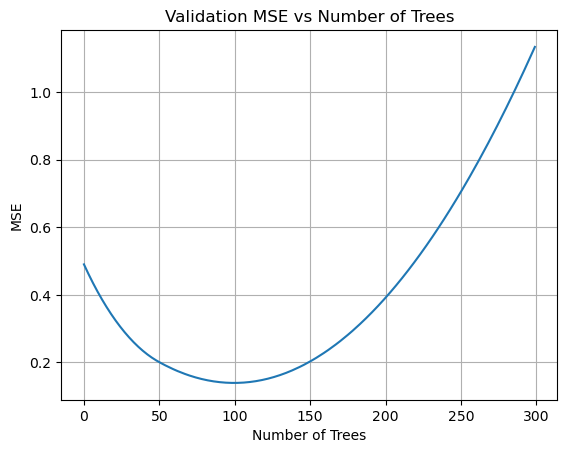

In [30]:
import matplotlib.pyplot as plt
plt.plot( validation_accuracies)
plt.xlabel('Number of Trees')
plt.ylabel('MSE')
plt.title('Validation MSE vs Number of Trees')
plt.grid(True)
plt.show()

In [28]:
tree= classifiers[np.argmax(validation_accuracies)]
prediction = np.array([predict(x, tree) for x in x_reduced_test],dtype = np.int64)
print("Test MSE on best Tree",np.mean((prediction- y_test)**2))

Test MSE on best Tree 0.5366430260047281


In [29]:
test_predictions = reg_boost_predict(classifiers, x_reduced_test)
print("Test error of Gradient Boosting",np.mean((test_predictions- y_test)**2))

Test error of Gradient Boosting 1.0784249246712925
